In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import mne
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import ghibtools as gh
import pandas as pd
import seaborn as sns
from params import *
from bibliotheque import get_pos, df_baseline, get_df_mask_chan_signif, keep_clean
from compute_global_dataframes import bandpower_concat_job
from configuration import base_folder
import os

In [3]:
mask_params = dict(markersize=15, markerfacecolor='y')

In [4]:
pos = get_pos()

In [5]:
metrics = ['power_mean','power_median','power_integral','relative_power']
indexes = ['band','session','chan','participant']

In [6]:
bandpower = bandpower_concat_job.get(global_key).to_dataframe()
bandpower = keep_clean(bandpower, metrics)

In [7]:
bandpower

dim_0 participant   session chan             band    power_mean   
0          0         P01  baseline  Fp1            delta  5.819311e-14  \
1          1         P01  baseline  Fp1            theta  8.779037e-15   
2          2         P01  baseline  Fp1            alpha  4.424699e-15   
3          3         P01  baseline  Fp1             beta  2.862022e-15   
4          4         P01  baseline  Fp1        low_gamma  2.434256e-15   
...      ...         ...       ...  ...              ...           ...   
19525  19525         P31      odor  Fp2            alpha  2.495842e-14   
19526  19526         P31      odor  Fp2             beta  4.530400e-15   
19527  19527         P31      odor  Fp2        low_gamma  1.542982e-15   
19528  19528         P31      odor  Fp2       high_gamma  7.057151e-16   
19529  19529         P31      odor  Fp2  very_high_gamma  3.696217e-16   

       power_median  power_integral  relative_power  stai_state  stai_trait   
0      4.016838e-14    1.740122e-13        0.074904          40          61  \
1      7.582653e-15    3.510414e-14        0.015111          40          61   
2      4.356204e-15    1.771455e-14        0.007625          40          61   
3      2.767516e-15    5.152823e-14        0.022180          40          61   
4      2.398931e-15    3.652031e-14        0.015720          40          61   
...             ...             ...             ...         ...         ...   
19525  2.003289e-14    1.001670e-13        0.084919          29          40   
19526  4.246664e-15    8.155280e-14        0.069138          29          40   
19527  1.401260e-15    2.314672e-14        0.019623          29          40   
19528  6.765634e-16    3.175706e-14        0.026923          29          40   
19529  3.542047e-16    3.696085e-14        0.031334          29          40   

       keep_session  Maia_Mean  
0                 1   1.019643  
1                 1   1.019643  
2                 1   1.019643  
3                 1   1.019643  
4                 1   1.019643  
...             ...        ...  
19525             1   2.790774  
19526             1   2.790774  
19527             1   2.790774  
19528             1   2.790774  
19529             1   2.790774  

[19530 rows x 13 columns]

In [8]:
bandpower_baselined = df_baseline(bandpower, indexes, metrics)

<AxesSubplot: >

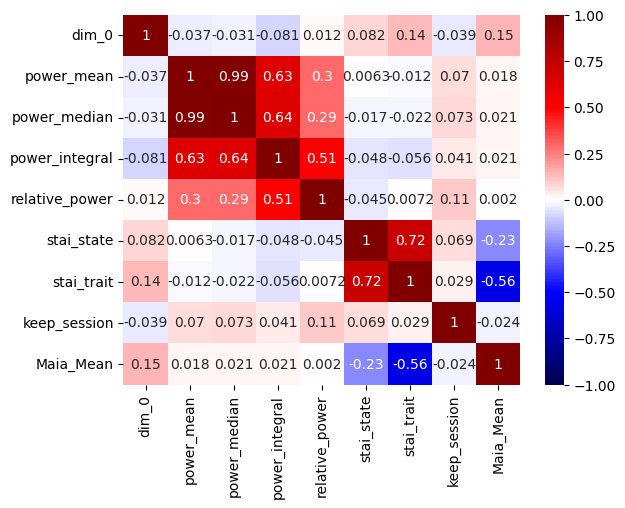

In [9]:
sns.heatmap(bandpower.corr(numeric_only = True), annot =True, vmin = -1, vmax = 1, cmap = 'seismic')

<AxesSubplot: >

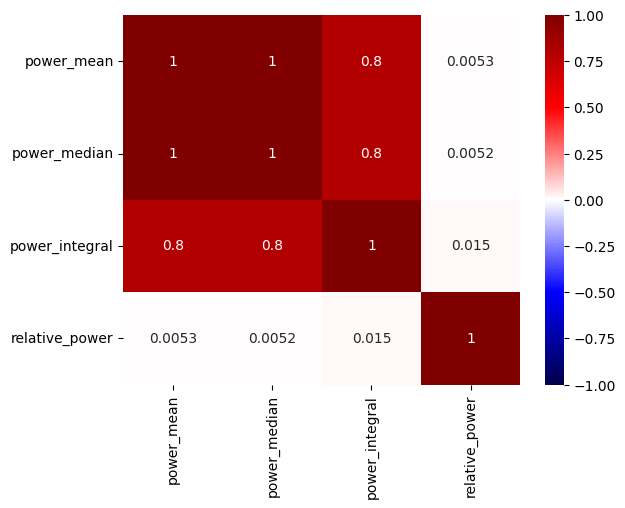

In [10]:
sns.heatmap(bandpower_baselined.corr(numeric_only = True), annot =True, vmin = -1, vmax = 1, cmap = 'seismic')

<AxesSubplot: xlabel='band', ylabel='power_integral'>

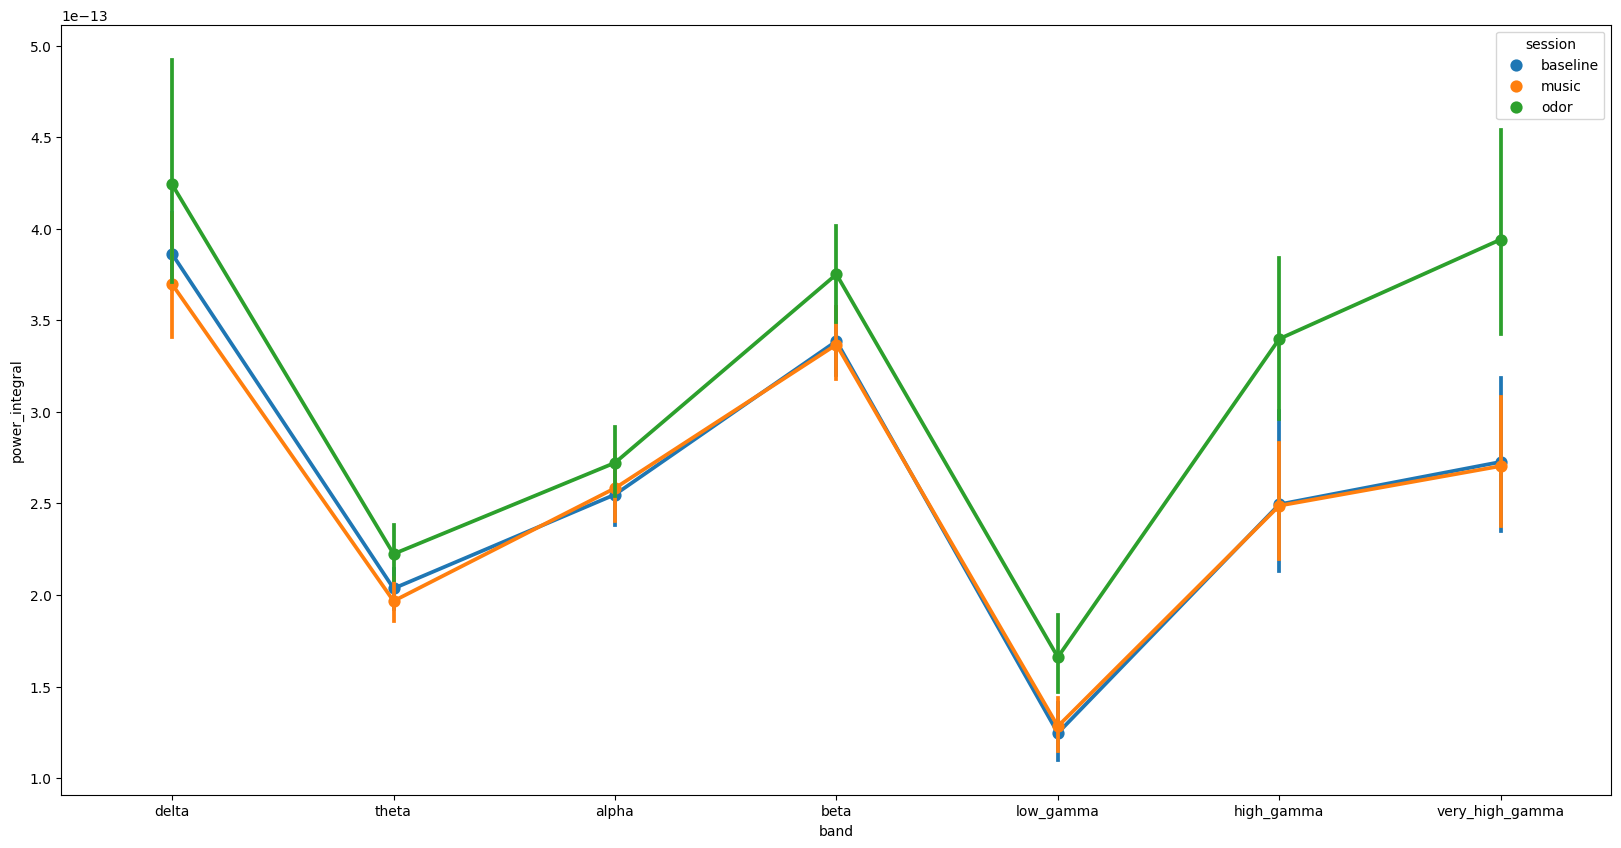

In [11]:
fig, ax = plt.subplots(figsize = (20,10))
sns.pointplot(data=bandpower, x = 'band', y = 'power_integral', hue = 'session',ax=ax)

<AxesSubplot: xlabel='band', ylabel='power_integral'>

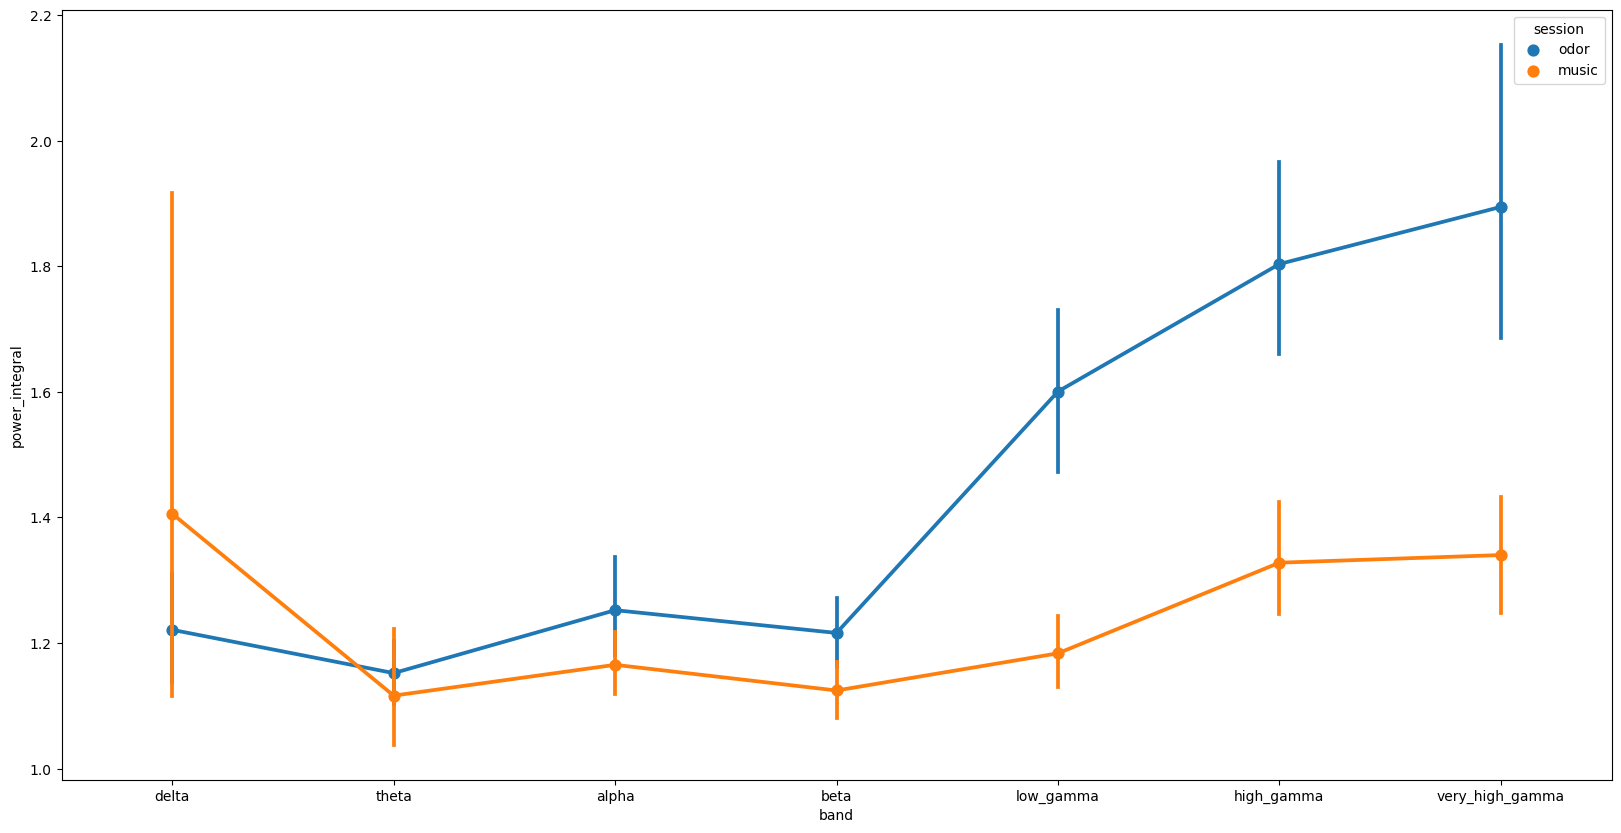

In [12]:
fig, ax = plt.subplots(figsize = (20,10))
sns.pointplot(data=bandpower_baselined, x = 'band', y = 'power_integral', hue = 'session',ax=ax)

/home/valentin.ghibaudo/.virtualenvs/py3.10_nodegpu/lib/python3.10/site-packages/scipy/stats/_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


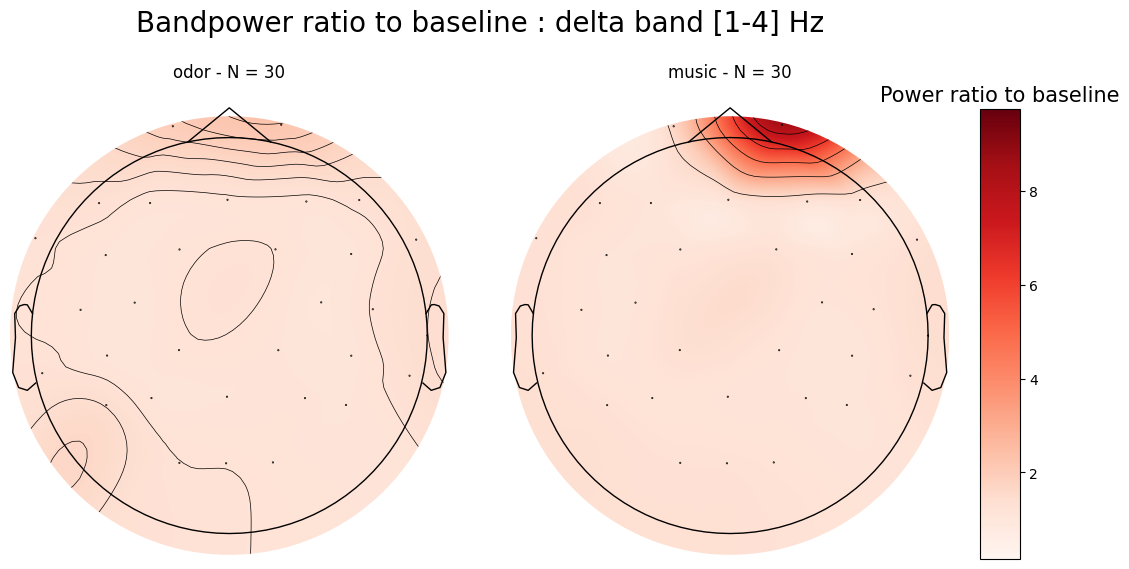

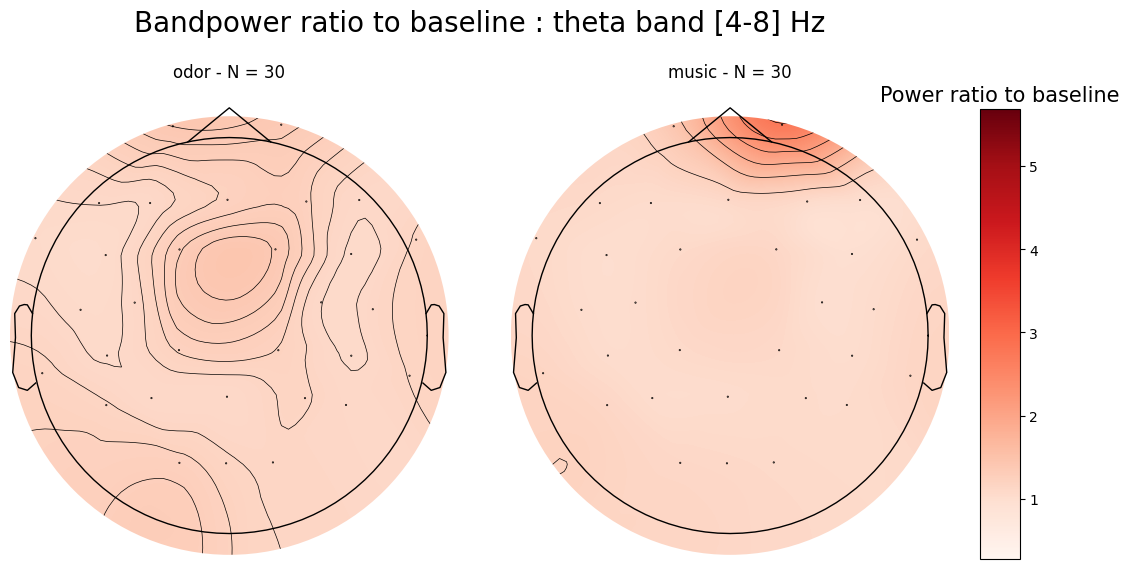

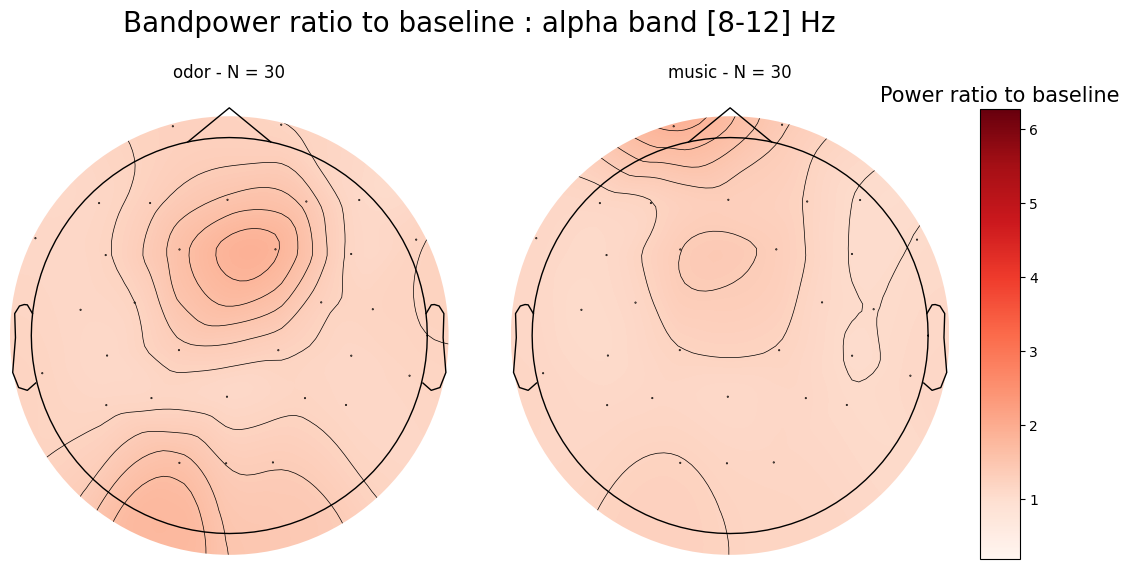

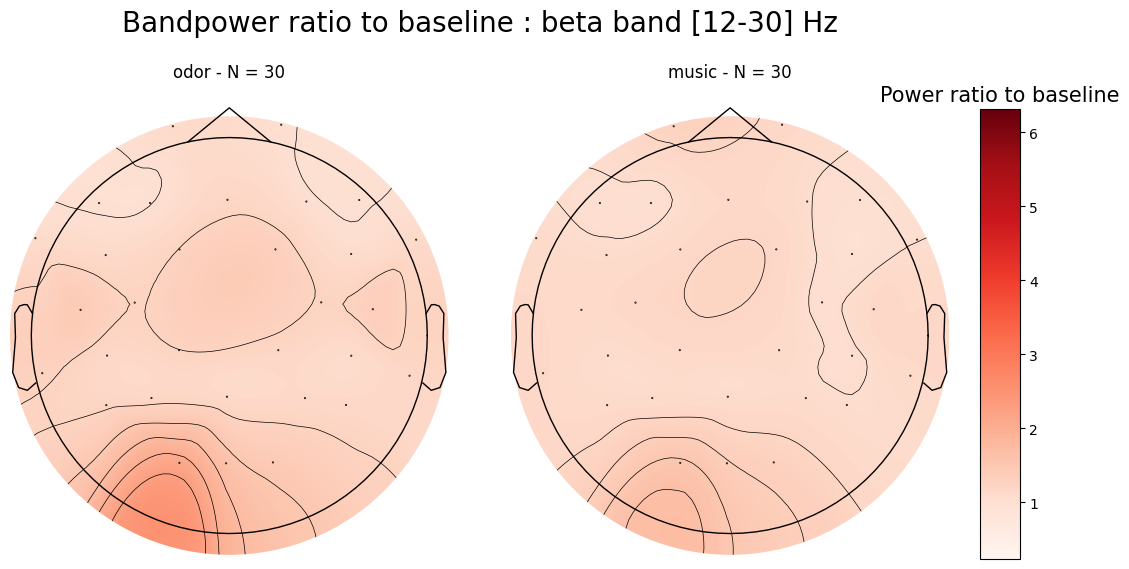

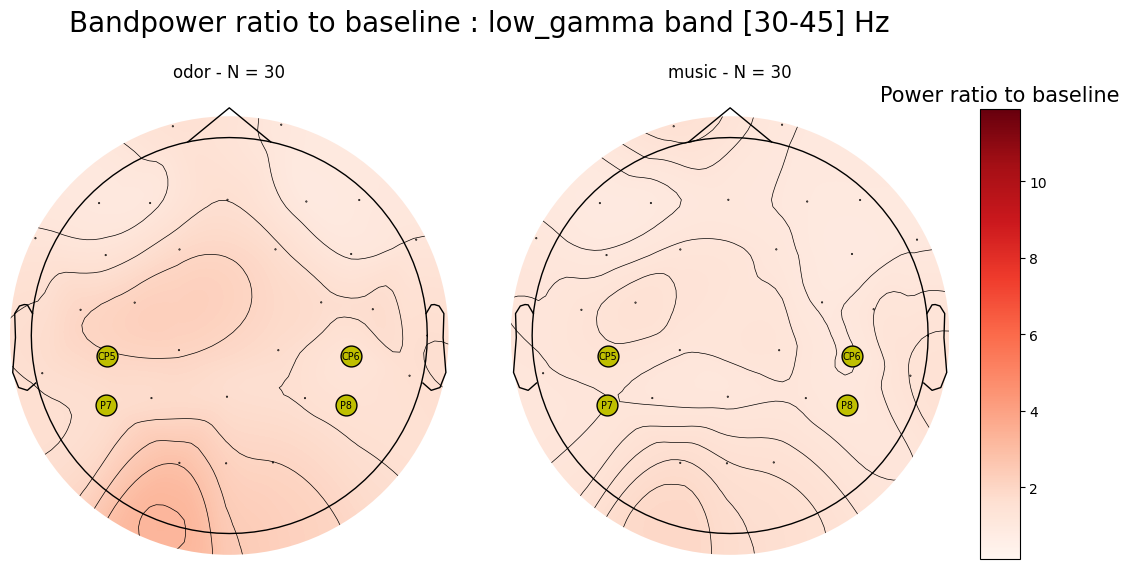

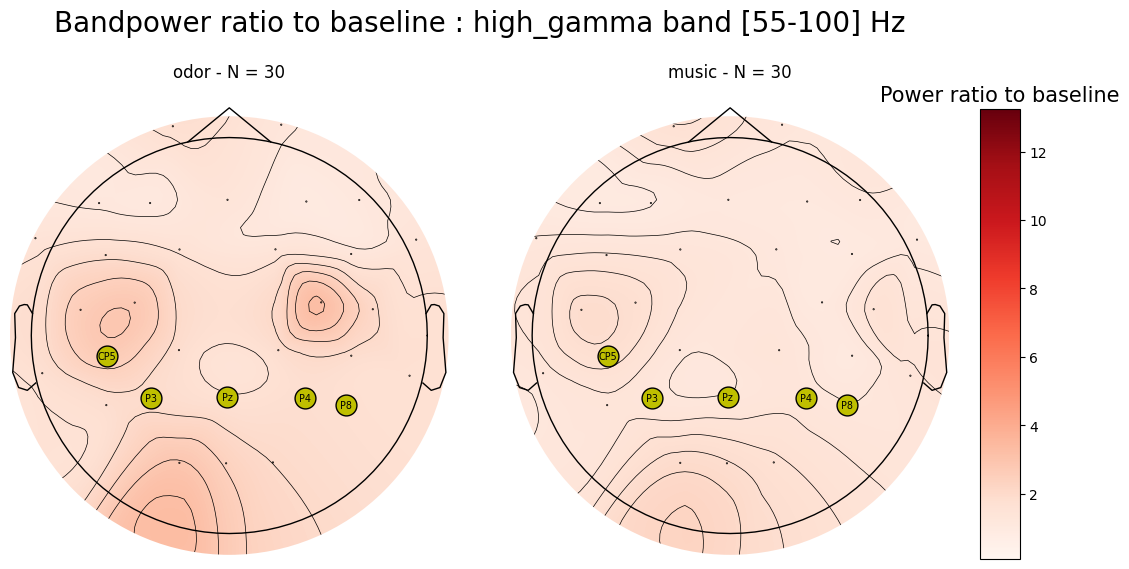

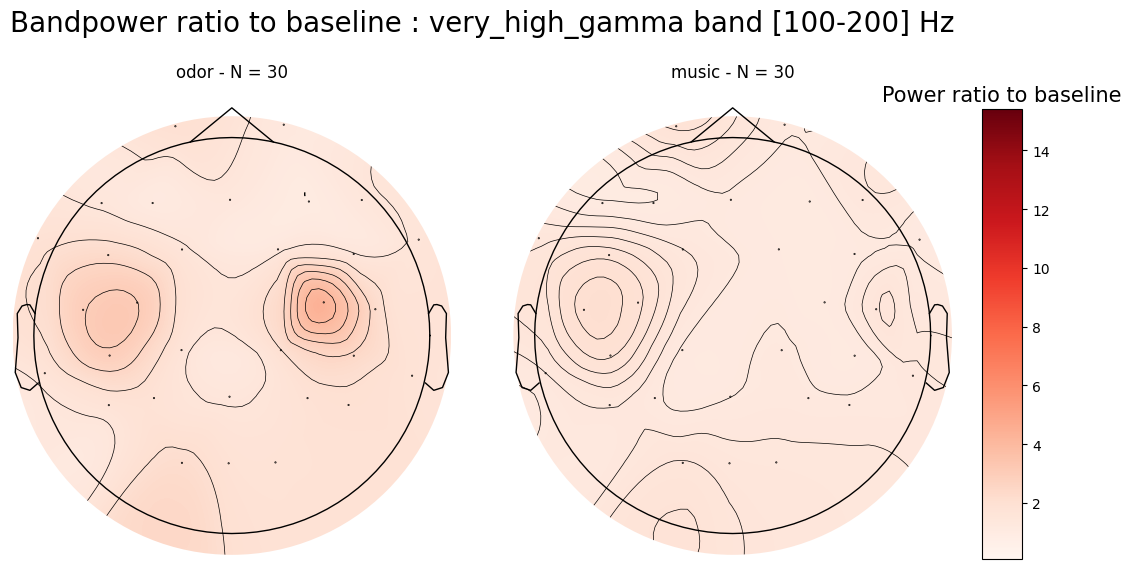

In [13]:
N = len(subject_keys)

for band in fbands.keys():
    bandpower_of_band = bandpower_baselined[bandpower_baselined['band'] == band]
    
    df_mask = get_df_mask_chan_signif(df = bandpower_of_band, chans = eeg_chans, predictor = 'session', outcome = 'power_integral', subject = 'participant')
    
    lc = fbands[band][0]
    hc = fbands[band][1]
    
    delta = 0.005
    mini = bandpower_of_band['power_integral'].quantile(delta)
    maxi = bandpower_of_band['power_integral'].quantile(1 - delta)
    
    vlim = (mini,maxi)

    fig, axs = plt.subplots(ncols = bandpower_of_band['session'].unique().size,figsize = (10,5), constrained_layout = True)
    fig.suptitle(f'Bandpower ratio to baseline : {band} band [{lc}-{hc}] Hz', fontsize = 20, y = 1.1)
    for c, session in enumerate(bandpower_of_band['session'].unique()):
        ax = axs[c]
        mask = bandpower_of_band[bandpower_of_band['session'] == session]
        data_ready = mask.groupby('chan').mean(numeric_only = True)['power_integral'].reindex(eeg_chans)
        data = data_ready.values
        im, _ = mne.viz.plot_topomap(data=data,pos = pos, names = eeg_chans, axes=ax, show = False, vlim=vlim, cmap = 'Reds', mask = df_mask['mask_corr'], mask_params = mask_params)
        
        ax.set_title(f'{session} - N = {N}')
        
    ax_x_start = 1
    ax_x_width = 0.04
    ax_y_start = 0
    ax_y_height = 0.9
    cbar_ax = fig.add_axes([ax_x_start, ax_y_start, ax_x_width, ax_y_height])
    clb = fig.colorbar(im, cax=cbar_ax)
    clb.ax.set_title('Power ratio to baseline',fontsize=15)
    
    file = base_folder / 'Figures' / 'bandpower' / 'global' / f'{band}.png'
    

    fig.savefig(file, bbox_inches = 'tight')


In [14]:
N = len(subject_keys)

for subject in subject_keys:
    bandpower_subject = bandpower_baselined[bandpower_baselined['participant'] == subject]
    for band in fbands.keys():
        bandpower_of_band = bandpower_subject[bandpower_subject['band'] == band]

        lc = fbands[band][0]
        hc = fbands[band][1]

        delta = 0.005
        mini = bandpower_of_band['power_integral'].quantile(delta)
        maxi = bandpower_of_band['power_integral'].quantile(1 - delta)
        vlim = (mini,maxi)

        fig, axs = plt.subplots(ncols = bandpower_of_band['session'].unique().size,figsize = (10,5), constrained_layout = True)
        fig.suptitle(f'{subject} - Bandpower ratio to baseline : {band} band [{lc}-{hc}] Hz', fontsize = 20, y = 1.1)
        for c, session in enumerate(bandpower_of_band['session'].unique()):
            ax = axs[c]
            mask = bandpower_of_band[bandpower_of_band['session'] == session]
            data_ready = mask.groupby('chan').mean(numeric_only = True)['power_integral'].reindex(eeg_chans)
            data = data_ready.values
            im, _ = mne.viz.plot_topomap(data=data,pos = pos, names = eeg_chans, axes=ax, show = False, vlim=vlim, cmap = 'Reds')

            ax.set_title(f'{session}')

        ax_x_start = 1
        ax_x_width = 0.04
        ax_y_start = 0
        ax_y_height = 0.9
        cbar_ax = fig.add_axes([ax_x_start, ax_y_start, ax_x_width, ax_y_height])
        clb = fig.colorbar(im, cax=cbar_ax)
        clb.ax.set_title('Power ratio to baseline',fontsize=15)
        
        save_folder = base_folder / 'Figures' / 'bandpower' / 'by_subject' / f'{band}'
        if not os.path.isdir(save_folder):
            os.mkdir(save_folder)
            
        file = save_folder / f'{subject}.png'
        fig.savefig(file, bbox_inches = 'tight')
        plt.close()